In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

## Baseline

Using TensorFlow backend.
2019-12-10 20:09:11,843:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-10 20:09:12,458:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-10 20:09:14,881:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-10 20:09:15,437:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-10 20:09:16,905:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-10 20:09:17,454:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs':

0.6725082146768894


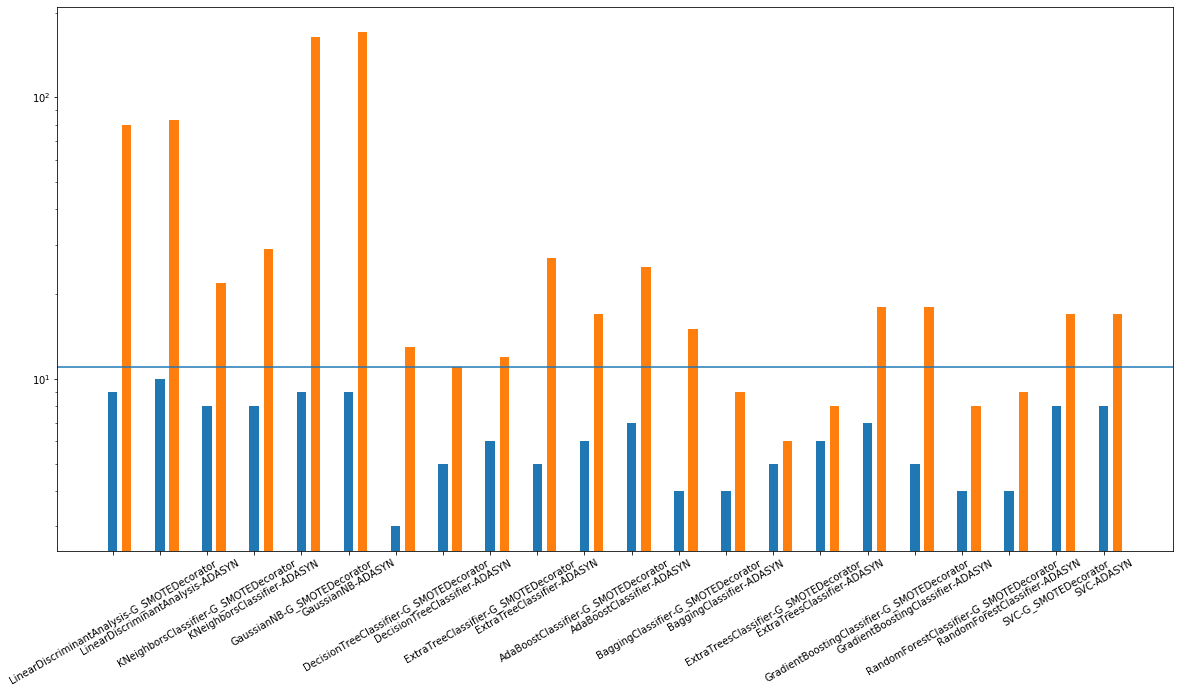

In [2]:
from src.evaluation import imbalanced_score, matthews_corrcoef_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from src.oversampling import G_SMOTEDecorator

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, SVC
]

X = pd.read_csv('../data/all_X.csv')
y = pd.read_csv('../data/all_y.csv', header=None).T.ix[0]

i_train, i_test = next(StratifiedShuffleSplit(test_size=0.2, random_state=40).split(X, y))

X_train, X_test, y_train, y_test = X.loc[i_train], X.loc[i_test], y.loc[i_train], y.loc[i_test]

tps, ts, gts, labels, scores = [], [], [], [], []
for Model in models:
    for oversampler in [G_SMOTEDecorator(), ADASYN()]:
        pipeline = Pipeline([
            ('OVERSAMPLER', oversampler), (Model.__name__, Model())
        ])
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        tps.append(sum(y_test & y_pred))
        ts.append(sum(y_pred))
        gts.append(sum(y_test))
        labels.append(f'{Model.__name__}-{oversampler.__class__.__name__}')
        scores.append(imbalanced_score(0.7)(clf, X_test, y_test))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

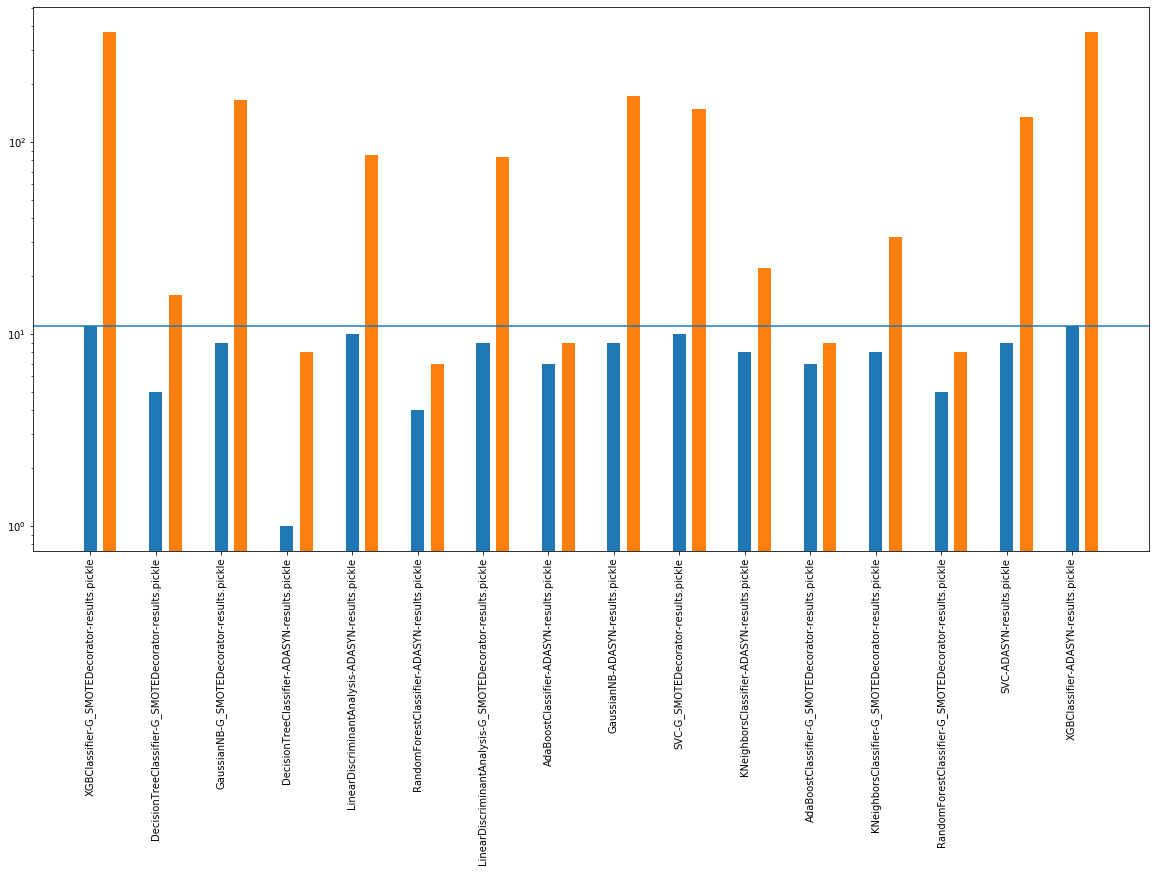

In [3]:
res_paths = glob('../experiments/model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels = [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        results, y_true, y_pred = pickle.load(fh)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])

In [4]:
res_paths = glob('../experiments/model_selection/results/*.pickle')
test_scores = {}

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        conf = pickle.load(fh)
    with open(str(path).rsplit('.', 1)[0] + '-results.pickle', 'rb') as fh:
        results, *_ = pickle.load(fh)
    
    results = pd.DataFrame(results)
    scores = results[results.params == conf].filter(regex='split\d_test*').values
    if len(scores) != 0:
        test_scores[path.name.rsplit('.', 1)[0]] = scores[0]
    else:
        test_scores[path.name.rsplit('.', 1)[0]] =\
            results[results.params.apply(lambda d: d.get('AdaBoostClassifier__n_estimators', None)) == conf['AdaBoostClassifier__n_estimators']]\
                .filter(regex='split\d_test*').values[0]
test_scores = list(test_scores.items())
test_scores = sorted(test_scores, key = lambda l: l[1].mean(), reverse=True)

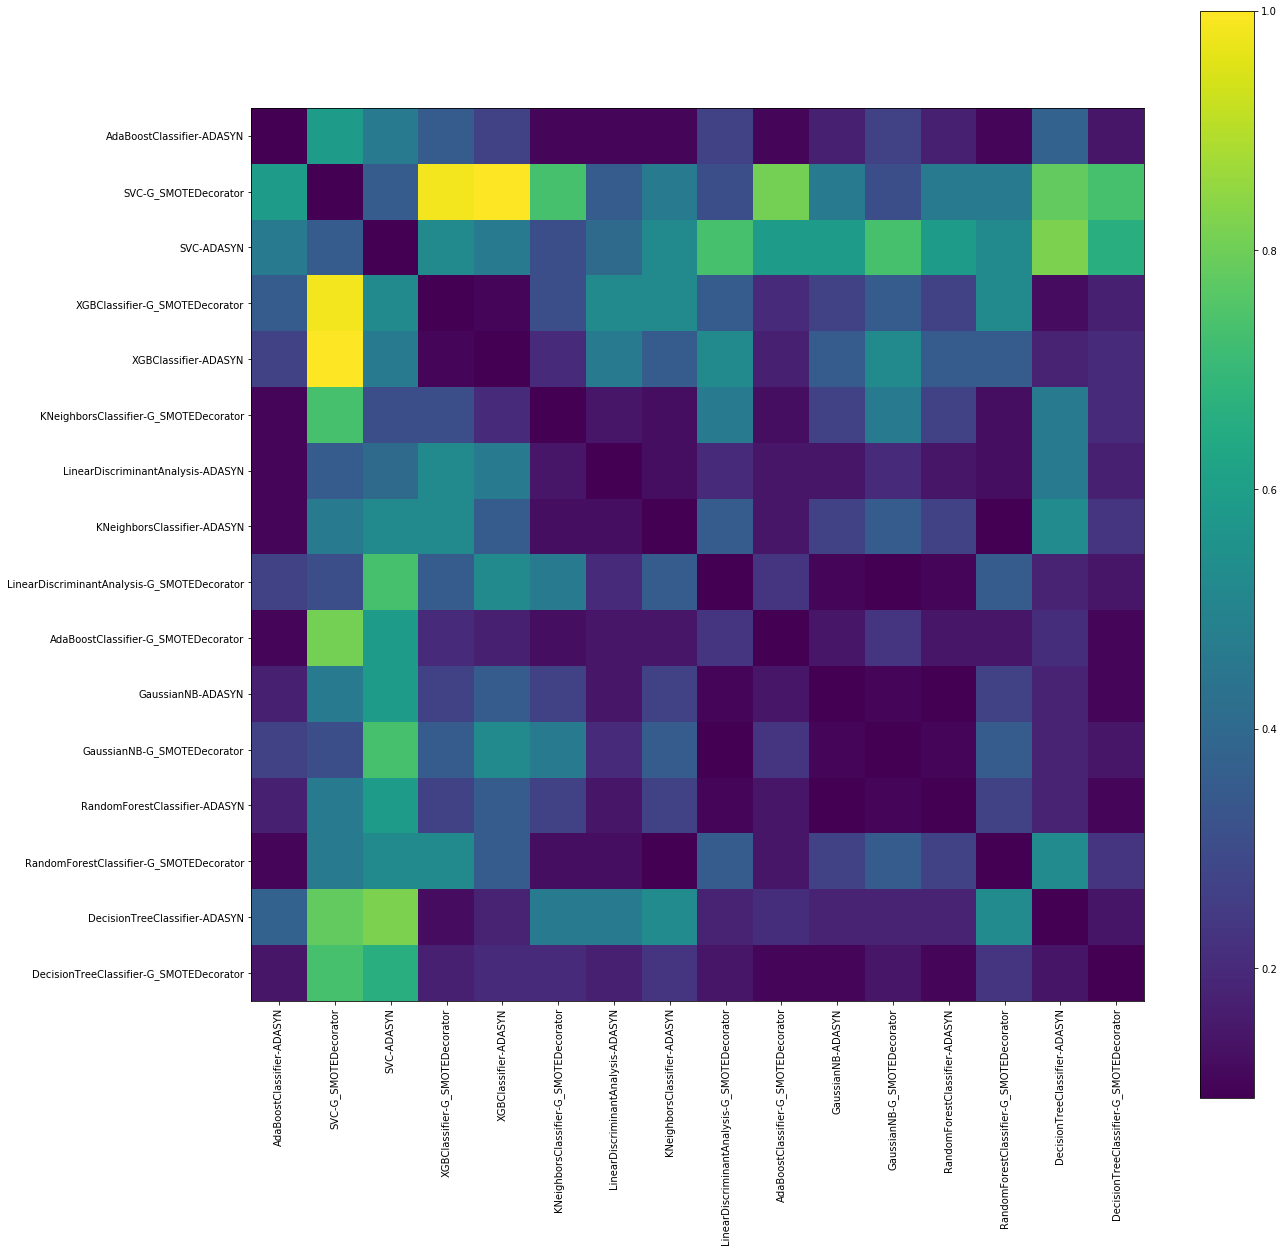

In [11]:
from scipy.stats import friedmanchisquare

tests = np.zeros(shape=(len(test_scores), len(test_scores)))
for i, (n1, s1) in enumerate(test_scores):
    for j, (n2, s2) in enumerate(test_scores):
        measurements = np.column_stack((s1, s2))
        tests[i][j] = friedmanchisquare(*measurements)[1]

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(tests)

plt.xticks(np.arange(len(test_scores)), [e[0] for e in test_scores], rotation='vertical')
plt.yticks(np.arange(len(test_scores)), [e[0] for e in test_scores])

ax.figure.colorbar(im, ax=ax)